## Učitavanje podataka

In [1]:
import numpy as np
import pandas as pd

dff = pd.read_csv(
        'elektroprecisceno.csv',
         index_col=0
)
dff

,godine,stariji,Pol,indikacija:,ukupno,trajanje,frekvenca,Blok,dimenzija,EDD,...,Sotalol,Digoksin,ASA,OAKT,Plavix,Statin,Implantiran,Vreme,"sinhroni,",Elektrokonverzija
Broj,,,,,,,,,,,,,,,,,,,,,
1,78,1,1,1,5,5,0,3,42,56,...,0,0,0,2,0,0,1,2,2,True
2,61,0,1,2,24,1,7,0,42,59,...,0,0,0,2,0,0,0,-1,2,True
3,65,1,1,1,4,4,0,3,47,55,...,0,0,0,2,0,0,1,3,2,True
4,64,0,1,1,288,2,7,0,50,50,...,0,0,0,2,0,0,0,-1,2,True
5,65,1,2,1,48,3,9,0,49,61,...,0,0,0,2,0,1,0,-1,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,61,0,1,2,2,2,0,3,36,54,...,0,0,0,2,0,0,1,2,2,True
647,58,0,1,2,12,2,0,3,45,57,...,0,0,0,3,0,1,1,2,2,True
648,72,1,2,1,20,20,6,0,43,66,...,0,1,0,3,0,0,0,-1,2,True


## Priprema (diskretizacija)

In [2]:
df = dff.copy()
corrs = []

def izmeni(**kwargs):
    [(att, bins)] = kwargs.items()
    df[att] = np.digitize(df[att], bins)
    return np.corrcoef(df[att], dff[att])[0, 1]

corrs.append(izmeni(godine = range(10, 100, 10)))
corrs.append(izmeni(ukupno = [4, 10, 30, 61]))
corrs.append(izmeni(trajanje = [3, 10]))
corrs.append(izmeni(dimenzija = range(30, 56, 5)))
corrs.append(izmeni(EDD = range(40, 66, 5)))
corrs.append(izmeni(ESD = range(20, 66, 5)))
corrs.append(izmeni(EF = range(20, 80, 5)))
corrs.append(izmeni(Vreme = [0, 3, 10]))

print(corrs)
df

[0.973269468814355, 0.7288493613422512, 0.8362367777252501, 0.9546193076544146, 0.9293852629054578, 0.9831993952007181, 0.9920791972032856, 0.5697974385743548]


,godine,stariji,Pol,indikacija:,ukupno,trajanje,frekvenca,Blok,dimenzija,EDD,...,Sotalol,Digoksin,ASA,OAKT,Plavix,Statin,Implantiran,Vreme,"sinhroni,",Elektrokonverzija
Broj,,,,,,,,,,,,,,,,,,,,,
1,7,1,1,1,1,1,0,3,3,4,...,0,0,0,2,0,0,1,1,2,True
2,6,0,1,2,2,0,7,0,3,4,...,0,0,0,2,0,0,0,0,2,True
3,6,1,1,1,1,1,0,3,4,4,...,0,0,0,2,0,0,1,2,2,True
4,6,0,1,1,4,0,7,0,5,3,...,0,0,0,2,0,0,0,0,2,True
5,6,1,2,1,3,1,9,0,4,5,...,0,0,0,2,0,1,0,0,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,6,0,1,2,0,0,0,3,2,3,...,0,0,0,2,0,0,1,1,2,True
647,5,0,1,2,2,0,0,3,4,4,...,0,0,0,3,0,1,1,1,2,True
648,7,1,2,1,2,2,6,0,3,6,...,0,1,0,3,0,0,0,0,2,True


## Podela na test i trening

In [3]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, random_state=0, stratify=df.iloc[:,-1], test_size=0.33)

## Pomoćne funkcije

In [4]:
import bnlearn as bn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def dohvati(model, tren, test):
    if 'config' in model: print(model['config'])
    if tren is not None: model = bn.parameter_learning.fit(model, tren, verbose=0)
    
    ciljna = test.columns[-1]
    y_true, y_pred = [], []
    for _, row in test.iterrows():
        ev = {att: row[att] for att in model['adjmat'] if att in row[:-1]}
        p = bn.inference.fit(model, variables=[ciljna], evidence=ev, verbose=0)
        y_true.append(row[ciljna])
        y_pred.append(p.get_value(**{ciljna: True})[0][-1])
    return y_pred, y_true

def oceni(y_pred, y_true, thresh=0.5):
    y_pred = [y > thresh for y in y_pred]
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

def nacrtaj(x, y, naslov):
    x, y = np.array(x), np.array(y)
    plt.scatter(x[y], y[y])
    plt.scatter(x[~y], y[~y])
    plt.title(naslov)
    plt.vlines(0.5, -0.05, 1.05, 'red')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel('Predviđeno')
    plt.ylabel('Stvarno')
    plt.show()

## Učenje strukture $\tiny \text{(relativno preprilagođeno)}$

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Plot based on BayesianModel


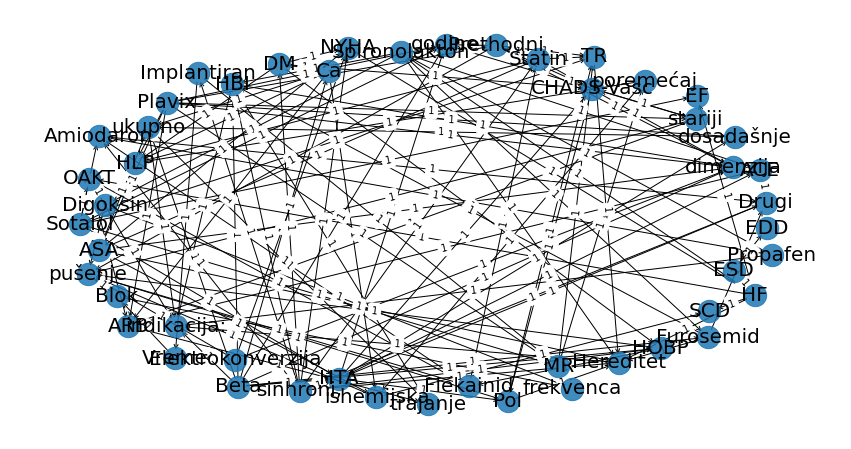

In [5]:
#from itertools import product

models = [bn.structure_learning.fit(df_train),]
#          bn.structure_learning.fit(df_train, 'cs', verbose=0),
#          *(bn.structure_learning.fit(df, m, s) for m, s in prod(('hc', 'ex'), ('bic', 'k2', 'bdeu'))),
#          *(bn.structure_learning.fit(df_train, 'cl', root_node=att, verbose=0) for att in df.columns)]

_ = bn.plot(models[0])

{'verbose': 3, 'method': 'hc', 'scoring': 'bic', 'black_list': None, 'white_list': None, 'bw_list_method': None, 'max_indegree': None, 'tabu_length': 100, 'epsilon': 0.0001, 'max_iter': 1000000.0, 'root_node': None}
[[ 8  3]
 [ 2 85]]
              precision    recall  f1-score   support

       False       0.80      0.73      0.76        11
        True       0.97      0.98      0.97        87

    accuracy                           0.95        98
   macro avg       0.88      0.85      0.87        98
weighted avg       0.95      0.95      0.95        98



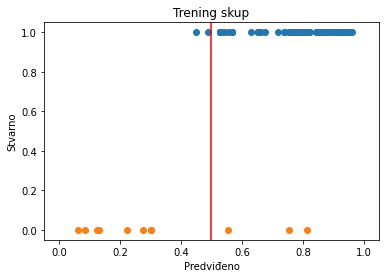

In [6]:
for model in models:
    trenx, treny = dohvati(model, df_train, df_train)
    oceni(trenx, treny)
    nacrtaj(trenx, treny, 'Trening skup')

{'verbose': 3, 'method': 'hc', 'scoring': 'bic', 'black_list': None, 'white_list': None, 'bw_list_method': None, 'max_indegree': None, 'tabu_length': 100, 'epsilon': 0.0001, 'max_iter': 1000000.0, 'root_node': None}
[[ 1  5]
 [ 4 39]]
              precision    recall  f1-score   support

       False       0.20      0.17      0.18         6
        True       0.89      0.91      0.90        43

    accuracy                           0.82        49
   macro avg       0.54      0.54      0.54        49
weighted avg       0.80      0.82      0.81        49



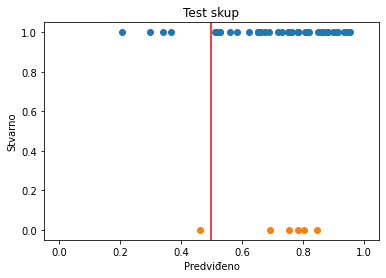

In [7]:
for model in models:
    testx, testy = dohvati(model, df_train, df_test)
    oceni(testx, testy)
    nacrtaj(testx, testy, 'Test skup')

## Naivni Bajes $\tiny \text{(apsolutno potprilagođen)}$

[bnlearn] >No changes made to existing Bayesian DAG.
[bnlearn] >Plot based on BayesianModel


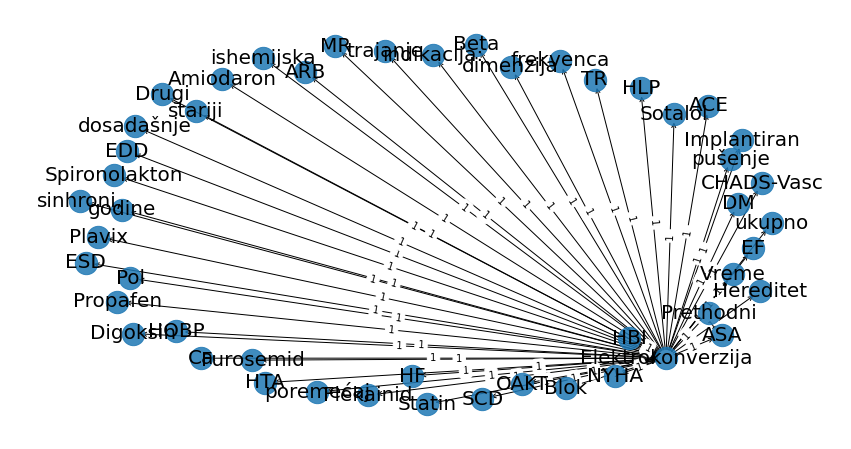

In [8]:
from pgmpy.models import NaiveBayes

nb = NaiveBayes()
nb.fit(df_train, 'Elektrokonverzija')
nb = bn.make_DAG(nb)

_ = bn.plot(nb)

[[ 0 11]
 [ 0 87]]
              precision    recall  f1-score   support

       False       0.00      0.00      0.00        11
        True       0.89      1.00      0.94        87

    accuracy                           0.89        98
   macro avg       0.44      0.50      0.47        98
weighted avg       0.79      0.89      0.83        98



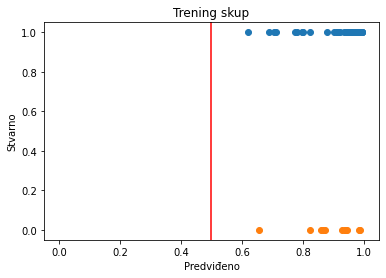

In [9]:
trenx, treny = dohvati(nb, df_train, df_train)
oceni(trenx, treny)
nacrtaj(trenx, treny, 'Trening skup')

[[ 0  6]
 [ 0 43]]
              precision    recall  f1-score   support

       False       0.00      0.00      0.00         6
        True       0.88      1.00      0.93        43

    accuracy                           0.88        49
   macro avg       0.44      0.50      0.47        49
weighted avg       0.77      0.88      0.82        49



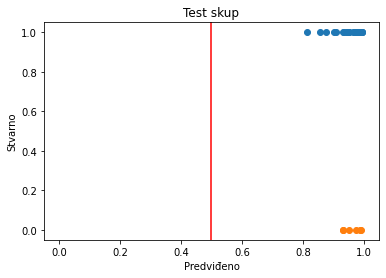

In [10]:
testx, testy = dohvati(nb, df_train, df_test)
oceni(testx, testy)
nacrtaj(testx, testy, 'Test skup')

## Ručni naivni $\tiny \text{(osrednje preprilagođen)}$

[[10  1]
 [ 4 83]]
              precision    recall  f1-score   support

       False       0.71      0.91      0.80        11
        True       0.99      0.95      0.97        87

    accuracy                           0.95        98
   macro avg       0.85      0.93      0.89        98
weighted avg       0.96      0.95      0.95        98



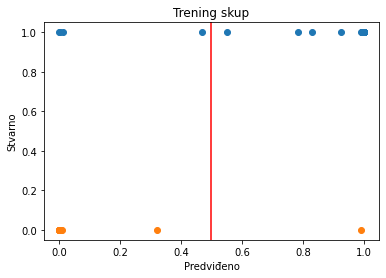

[[ 0  6]
 [ 1 42]]
              precision    recall  f1-score   support

       False       0.00      0.00      0.00         6
        True       0.88      0.98      0.92        43

    accuracy                           0.86        49
   macro avg       0.44      0.49      0.46        49
weighted avg       0.77      0.86      0.81        49



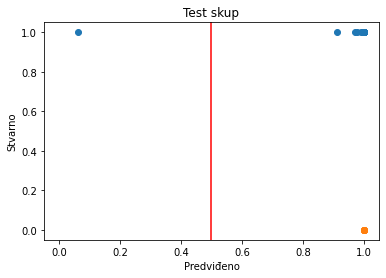

In [11]:
from functools import reduce
from operator import mul

prod = lambda niz: reduce(mul, niz, 1)
norm = lambda dic: (np.array([*dic.values()]) / np.sum(np.array([*dic.values()])))[1]

class MojNaivniBajes:
    def fit(self, df_train):
        self.ulazni = df_train.columns[:-1]
        self.ciljni = df_train.columns[-1]
        
        self.klase = sorted(list(set(df_train[self.ciljni])))
        
        self.probs = {klasa: {atribut: 16*[0.00005] for atribut in self.ulazni} for klasa in self.klase}
        
        self.vrvk = {klasa: len(df_train[df_train[self.ciljni] == klasa]) / len(df_train) for klasa in self.klase}
        
        for indeks in df_train.index:
            klasa = df_train.loc[indeks, self.ciljni]
            for atribut in self.ulazni:
                self.probs[klasa][atribut][df_train.loc[indeks, atribut]] += 1/self.vrvk[klasa]
    
    def predict(self, df_test):
        y_pred = []
        
        for indeks in df_test.index:
            odabir = {klasa: prod([self.probs[klasa][atribut][df_test.loc[indeks, atribut]]
                                   for atribut in self.ulazni]) for klasa in self.klase}
            y_pred.append(norm(odabir))
        
        return y_pred
    
    def score(self, df_test, naslov):
        y_true = df_test.loc[:, self.ciljni]
        y_pred = self.predict(df_test)
        
        oceni(y_pred, y_true)
        nacrtaj(y_pred, y_true, naslov)

mnb = MojNaivniBajes()
mnb.fit(df_train)
mnb.score(df_train, 'Trening skup')
mnb.score(df_test, 'Test skup')

## Forsiranje grana $\tiny \text{(apsolutno preprilagođeno)}$

  0%|          | 129/1000000 [02:11<282:22:29,  1.02s/it] 


[bnlearn] >No changes made to existing Bayesian DAG.
[bnlearn] >Plot based on BayesianModel


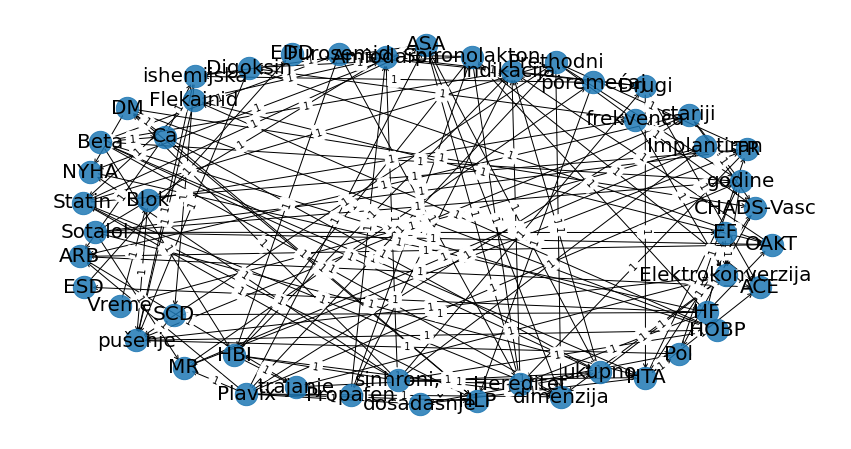

In [12]:
from pgmpy.estimators import HillClimbSearch

est = HillClimbSearch(df_train)
fixed = est.estimate(fixed_edges=[('godine', 'Elektrokonverzija'),
                                  ('ukupno', 'Elektrokonverzija'),
                                  ('frekvenca', 'Elektrokonverzija'),
                                  ('EF', 'Elektrokonverzija')])
fixed = bn.make_DAG(fixed)

_ = bn.plot(fixed)

[[11  0]
 [ 0 87]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        11
        True       1.00      1.00      1.00        87

    accuracy                           1.00        98
   macro avg       1.00      1.00      1.00        98
weighted avg       1.00      1.00      1.00        98



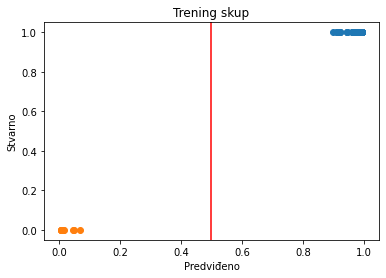

In [13]:
trenx, treny = dohvati(fixed, df_train, df_train)
oceni(trenx, treny)
nacrtaj(trenx, treny, 'Trening skup')

[[ 2  4]
 [16 27]]
              precision    recall  f1-score   support

       False       0.11      0.33      0.17         6
        True       0.87      0.63      0.73        43

    accuracy                           0.59        49
   macro avg       0.49      0.48      0.45        49
weighted avg       0.78      0.59      0.66        49



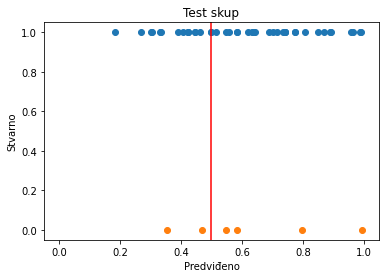

In [14]:
testx, testy = dohvati(fixed, df_train, df_test)
oceni(testx, testy)
nacrtaj(testx, testy, 'Test skup')